In [43]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import statistics as st
import random
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
df = pd.read_csv("train.csv")
X = df[[col for col in df.columns if col != 'target' and df[col].dtype in ['int64', 'float64']]]
y = df.target


In [49]:
mean_age = int(st.mean([age for age in df['Age'] if 13 <= age <= 102]))    # The mean age between logical age values
ages = df.Age[(df['Age'] <= 70) & (df['Age'] >= 13)].value_counts().to_dict() 
ages = dict(map(lambda age: (age, ages[age] / sum(ages.values())), ages.keys()))   # probability distribution of each of the logical age values
age_values = [age for age in ages.keys()]; age_proba = [proba for proba in ages.values()]   # ages and their probabilities

def homogenize_age(age: int) -> int:   # Randomly assigns a non-logical age to a logical one based on probability distribution of the other ages
    if not 13 <= age <= 65 or age == np.nan:
        age = random.choices(list(ages.keys()), list(ages.values()))[0]
    return age

#df.Age.value_counts().to_dict()
X['Age'] = X['Age'].apply(lambda age: homogenize_age(age))

<ipython-input-49-5682c3582d53>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Age'] = X['Age'].apply(lambda age: homogenize_age(age))


In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.25, random_state = 2020)

model = lgb.LGBMClassifier(learning_rate = 0.9, max_depth = -5, random_state = 13)

model.fit(X_train, y_train, eval_set = [(X_valid, y_valid), (X_train, y_train)], verbose = 20, eval_metric = 'f1_score')

[20]	training's binary_logloss: 0.337099	valid_0's binary_logloss: 0.366508
[40]	training's binary_logloss: 0.336431	valid_0's binary_logloss: 0.36829
[60]	training's binary_logloss: 0.336154	valid_0's binary_logloss: 0.368869
[80]	training's binary_logloss: 0.336001	valid_0's binary_logloss: 0.369689
[100]	training's binary_logloss: 0.335888	valid_0's binary_logloss: 0.370455


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(learning_rate=0.9, max_depth=-5, random_state=13)

In [51]:
print('Training accuracy {:.4f}'.format(model.score(X_train, y_train)))

print('Validation accuracy {:.4f}'.format(model.score(X_valid, y_valid)))

Training accuracy 0.8822
Validation accuracy 0.8768


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

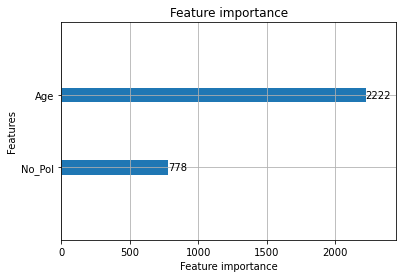

In [52]:
lgb.plot_importance(model)

In [53]:
print(classification_report(y_valid, model.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2652
           1       0.44      0.04      0.07       368

    accuracy                           0.88      3020
   macro avg       0.66      0.52      0.50      3020
weighted avg       0.83      0.88      0.83      3020



In [54]:
print(f1_score(y_train, model.predict(X_train)))

print(f1_score(y_valid, model.predict(X_valid)))

0.10561609388097233
0.0746268656716418
